<center><font size="+2"> <br>
Hidden Information in Restaurant Reviews<br>
Analyis Using Topic Modelling and Sententiment Analysis<br>
<font size="+1">CS410 Final Project Fall 2021<br>
John Hanratty (johnh7), Reynold Chan (cqchan2)</center><br><br>

# Installation and Configuration
REQUIREMENTS: This installation procedure was tested on Chrome, other browsers could be risky. *You need a personal or a University of Illinois Google account to access this notebook in Colab and the datasets.*

To configure access to the dataset and pretrained models$:$
1. Click [here](https://drive.google.com/drive/folders/170dh1q2UmLE2KXIwYBc1pjJzxSbkxWIj?usp=sharing) to view the CS410FinalProj directory in Google Drive that contains the data set files.  
2.  Click on the *CS410FinalProj* directory name at the top of the Google Drive screen.  This will display a dropdown menu. (see below)

<p align="center"><img src="https://drive.google.com/uc?export=view&id=157uIzcEWcEqBrHoD-J99OMo5CQ9HqX4K", alt="Google Docs Shortcut"
	title="Create Shortcut" width="500" height="350" /></p>

3. Select "Add Shortcut to Drive".  
4. Click on "My Drive" on the left side of the screen.  Verify that the "CS410FinalProj" folder is accessible in your "My Drive" folder.  (path: My Drive > CS410FinalProj).
5. If you haven't already, started the Colab notebook [here](https://drive.google.com/drive/folders/170dh1q2UmLE2KXIwYBc1pjJzxSbkxWIj?usp=sharing).  
6. In the notebook, click the first executable cell ("Remount Google Drive with ProjectDat) to mount your Google Drive. Complete the authentication steps.
7. (Optional) From the Colab Notebook, click the "folder" icon on the left and verify you have a directory  "/content/drive/MyDrive/CS410FinalProj".  You can click on CS410FinalProj to verify there are files.
8. On the notebook menu, click "Runtime" and from the dropdown menu select "Run all."

The cells in this notebook use the variable HOMEDIR to find the data files in your Google Drive at "/content/drive/MyDrive/CS410FinalProj" HOMEDIR is set in the "Load Libraries and Data Files" cell.  

You can also get the files in a zip file [here](https://drive.google.com/drive/folders/1YLPrs38gyvsw0gobxf7kZMjEMvVhHZ2F?usp=sharing) but you shouldn't need this.

If you have any problems, email johnh7@illinois.edu or cqchan2@illinois.edu.

For further instructions, Google instructions are [here](https://support.google.com/drive/answer/2375057?hl=en&co=GENIE.Platform%3DDesktop).


In [9]:
#@title Remount Google Drive with ProjectDat
#@markdown Run this to access the shared data files using the shortcut on your Google Drive. Follow the directions above to create the shortcut.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#@title Load Libraries and Data Files {display-mode: "form"}
#@markdown <a name="loadLib"></a>
#@markdown **RECOMENDATION:** Select "Run all" from the "Runtime" Colab menu.  You can save yourself some time by not waiting for individual cells to run.

#@markdown This cell loads configuration, libraries and data files that are used by *all scripts in this document.* 
#%%capture 
# %%capture hides output / remove if you need to debug

# clear all variables
%reset -f 

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

import os.path
HOMEDIR = '/content/drive/MyDrive/CS410FinalProj/'

if not os.path.isdir(HOMEDIR): 
  print('ERROR:  Google Drive data folder is not accessible.')
  print('Chech that Google Drive is mounted and', HOMEDIR, 'exists')
  print('If not, follow the Installation and Configure directions above.')
  raise StopExecution

from __future__ import print_function
from tqdm.notebook import tqdm

with tqdm(total=100) as pbar:
  import sys
  import time
  from datetime import datetime
  import pytz
  import json
  import numpy as np
  import pandas as pd
  import pickle
  from pprint import pprint
  from random import randint
  import warnings
  from google.colab import output
  import textwrap
  if 'prettytable' not in sys.modules:
    !pip3 install prettytable | grep -v 'already satisfied'
  from prettytable import PrettyTable

  if 'geopandas' not in sys.modules:
    !pip -q install geopandas | grep -v 'already satisfied'
  import geopandas as gpd
  if 'pyproj' not in sys.modules:
    !pip -q install pyproj | grep -v 'already satisfied'
  from pyproj import Proj, CRS, transform

  pbar.update(10)


  !pip -q install plotly>=4.7.1
  !wget -q https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca 
  !chmod +x /usr/local/bin/orca
  !apt-get -qq install xvfb libgtk2.0-0 libgconf-2-4 


  from shapely.geometry import Point, Polygon
  import matplotlib.pyplot as plt
  import seaborn as sns 
  import matplotlib.colors as mcolors

  import nltk
  from nltk.corpus import stopwords
  from wordcloud import WordCloud, STOPWORDS
  nltk.download('stopwords', quiet=True)

  color = sns.color_palette()
  %matplotlib inline
  import plotly.offline as py
  py.init_notebook_mode(connected=True)
  import plotly.graph_objs as go
  import plotly.tools as tls
  import plotly.express as px


  # Jupyter Widgets
  # https://ipywidgets.readthedocs.io/en/latest/changelog.html?highlight=interact_manual 
  from ipywidgets import Layout, interact, interactive, interactive_output, fixed, IntSlider, RadioButtons
  import ipywidgets as widgets

  from sklearn.feature_extraction import text
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from sklearn.decomposition import NMF, LatentDirichletAllocation
  from sklearn.model_selection import train_test_split

  if 'colorama' not in sys.modules:
    print('...installing colorama')
    !pip -q install colorama | grep -v 'already satisfied'
  from colorama import Fore, Back, Style

  DSREV_SAVE = HOMEDIR + 'ds_yelp_rev_dsMA'
  DSBIZ_SAVE = HOMEDIR + 'ds_yelp_biz_dsMA'
  DSID = 'YELP500K'  # IMDB, YELP
  DSTRAIN = HOMEDIR + 'cs410' + DSID + '_ds_train'
  DSTEST = HOMEDIR + 'cs410' + DSID + '_ds_test'
  DS_SENTIMENT = HOMEDIR + 'cs410' + DSID + '_ds_sentiment'

  # for Gensim Models
  LDAMODEL = HOMEDIR + 'cs410' + DSID + '_ldamodel'
  BOwTEST = HOMEDIR + 'cs410' + DSID + '_bow_test'
  BOwTRAIN = HOMEDIR + 'cs410' + DSID + '_bow_train'
  LDADICT = HOMEDIR + 'cs410' + DSID + '_dict'
  # for Scikit Models
  SCIMODEL_LDA = HOMEDIR + 'cs410' + DSID + '_scimodel_lda'
  SCIMODEL_NMF = HOMEDIR + 'cs410' + DSID + '_scimodel_nmf'
  SCIMODEL_TFLDA = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda'
  SCIMODEL_TFNMF = HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmf'
  SCIMODEL_TFLDA_VECT = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda_vect'
  SCIMODEL_TFNMF_VECT = HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmfvect'
  SCIMODEL_NMF_FEATURES = HOMEDIR + 'cs410' + DSID + '_scimodel_ldafeatures'
  SCIMODEL_LDA_FEATURES = HOMEDIR + 'cs410' + DSID + '_scimodel_nmffeatures'
  SCIMODEL_TFNMF_TFIDF =  HOMEDIR + 'cs410' + DSID + '_scimodel_tfnmf_tfidf'
  SCIMODEL_TFLDA_TF = HOMEDIR + 'cs410' + DSID + '_scimodel_tflda_tf'

  #READ YELP REVIEW and BUSINESS DATA SETS
#  with open(DSREV_SAVE, 'rb') as f:
#    yelp_ds1 = pickle.load(f)
#  yelp_ds1.reset_index(drop=True, inplace=True)

  pbar.update(10)

  with open(DSBIZ_SAVE, 'rb') as f:
    business_df = pickle.load(f)
  business_df.reset_index(drop=True, inplace=True)

  pbar.update(10)

  # READ TEST AND DATA SETS
  with open(DSTRAIN, 'rb') as f:
      ds_train = pickle.load(f)
      ds_trainx = ds_train.copy()

  pbar.update(10)

  with open(DSTEST, 'rb') as f:
      ds_test = pickle.load(f)
      ds_testx = ds_test.copy()
      
  pbar.update(10)

  with open(DS_SENTIMENT, 'rb') as f:
      ds_sentiment = pickle.load(f)
      ds_sentimentx = ds_sentiment.copy()

  #READ PRE-TRAINED SCIKIT MODELS
  with open(SCIMODEL_LDA, 'rb') as f:
      lda = pickle.load(f)

  pbar.update(10)

  with open(SCIMODEL_TFLDA, 'rb') as f:
      tf_fit = pickle.load(f)

  with open(SCIMODEL_TFLDA_VECT, 'rb') as f:
      tf_vectorizer = pickle.load(f)

  pbar.update(10)

  with open(SCIMODEL_TFLDA_TF, 'rb') as f:
      tf = pickle.load(f)

  with open(SCIMODEL_LDA_FEATURES, 'rb') as f:
      tf_feature_names = pickle.load(f)

  pbar.update(10)

  with open(SCIMODEL_NMF, 'rb') as f:
      nmf = pickle.load(f)

  with open(SCIMODEL_TFNMF, 'rb') as f:
      tfidf_fit = pickle.load(f)

  pbar.update(10)

  with open(SCIMODEL_TFNMF_VECT, 'rb') as f:
      tfidf_vectorizer = pickle.load(f)

  pbar.update(10)

  with open(SCIMODEL_TFNMF_TFIDF, 'rb') as f:
      tfidf = pickle.load(f)

  with open(SCIMODEL_NMF_FEATURES, 'rb') as f:
      tfidf_feature_names = pickle.load(f)

  # Initialize TOPIC_NAMES - can be edited in main body of notebook
  TOPIC_NAMES = {'L0': '**Brunch-',
  'L1': 'Location-',
  'L2': '*Food',
  'L3': 'Visiting',
  'L4': 'Order/Delivery',
  'L5': '**Service',
  'L6': 'Middle Easter',
  'L7': 'Italian/Pasta',
  'L8': 'Payment',
  'L9': 'Burgers',
  'L10': 'Cuisine',
  'L11': '*Friendly Staff',
  'L12': 'Indian',
  'L13': '**Breakfast',
  'L14': 'Seafood',
  'L15': 'Experienc',
  'L16': 'Burritos',
  'L17': 'Sick/Complaint',
  'L18': 'Hearty',
  'L19': '*Bar/Location',
  'T0': '**Food',
  'T1': 'Pizza',
  'T2': 'Great Atmosphere',
  'T3': '**Wait',
  'T4': 'Seafood',
  'T5': '**Value',
  'T6': 'Coffee',
  'T7': 'Sushi',
  'T8': '**Deliver/Service',
  'T9': '**Recommend',
  'T10': 'Thai',
  'T11': 'Food2',
  'T12': 'Friendly Staff',
  'T13': 'Burger',
  'T14': '**Favorite',
  'T15': '*Bar/Fun',
  'T16': '*?LunchDinnerBuffet',
  'T17': '*Breakfast/Brunch',
  'T18': '*Sandwiches',
  'T19': 'Amazing'
  }

  pbar.update(10)


  print('DS_TRAIN SHAPE:', ds_train.shape)
  print('DS_TEST SHAPE:', ds_test.shape)



# Routine for findng out how many topics are used in a model
def topic_count(mod):
  try:  
    p = mod.get_params()['n_components']
    return p
  except:
    pass
  try:
    p = mod.get_topics().shape[0]
    return p
  except:
    p = 10
  return p








  0%|          | 0/100 [00:00<?, ?it/s]

DS_TRAIN SHAPE: (500000, 12)
DS_TEST SHAPE: (100000, 12)


# Contents
This report follow the structure outlined in the assignment document$:$ Overview, Implemntation, Usage, and Contributions.
- [**OVERVIEW**](#Overview)
- [**IMPLEMENTION**](#dataset)
  - [SENTIMENT MODEL](#Sentiment)
  - [DATA SET CREATION](#dataset)
  - [TOPIC MODEL AND DISCOVERY](#Topic)
- [**USAGE**](#Analysis)
  - [ANALYZING CUSTOMER DATA WITH THE MODELS](#Analysis)
  - [EXAMPLE CUSTOMER REPORTS](#Reports)
- [**CONTRIBUTIONS**](#Contributions)
- [APPENDIX](#appendix)

<a name="Overiew"></a>
# OVERVIEW
This final project uses data mining techniques to analyze textual restaurant reviews by customers to understand and quantify preferences and satisfaction. The application utilizes latent topics extracted from review text to categorize customer interests.  Customer sentiment is also extracted from the reviews to augment time, location, ratings, and user information in the data set.  Use cases for this application include$:$

- Informing restaurant owners on how they stack up,
- Identifying topics that drive customer satisfaction,
- Giving customers better selection criteria for choosing a place to eat.

Our application ingests a large corpus of Yelp restaurant reviews to extract latent topics and customer sentiment. The raw JSON data set provided by Yelp was processed to provide rich customer review text with date, user, location, and other useful contextual information (e.g., ratings). The project allowed us to evaluate a number of topic and sentiment modeling techniques to augment the review data. The contextual data from the data set was enriched with extracted topic and sentiment information to enable better analysis of customer experiences. 

The final model and a test data set (different from training data) are used to create reports that expose actionable insights that help restaurants improve customer experience and customers choose restaurants via finer-grained preferences.  Several example reports are presented in this document.



<a name="Contributions"></a>
#CONTRIBUTIONS

### John Hanratty
- Researched and extracted the data set from the Yelp corpus
- Developed and performed all topic modelling and evaluation 
- Developed customer reports 
- Formatted and wrote sections above in this report


### Reynold Chan
- Developed the sentiment model
- Wrote sentiment sections for this report
- Performed final dataset and Jupyter/Colabs packaging for submission
- Edited this report
- Performed final demo video

<a name="dataset"></a>
# INPLEMENTATION$:$ DATA SET CREATION FROM YELP
The application utilizes restaurant review data set from [Yelp Open Dataset](https://www.yelp.com/dataset).  The original raw dataset contains$:$
- 8.6M reviews (7GB)
- 160K businesses (124MB)
- 2.2M users (3.4GB)
- 200K pictures
- 8 metropolitan areas

The raw dataset is available from Yelp in JSON format with separate files for reviews, businesses, users, tips, check-ins, and photos.  

The raw Yelp dataset was processed to create a smaller, focused data source for our application. Specifically, the business data (i.e., restaurants) and review data were joined and filtered to include only **restaurants in Massachusetts**. Data fields were filtered down, combined, and transformed to provide more succinct contextual data (e.g., reviews dates, location, ratings).  The final data set contained 1.36 million reviews which was divided into test and training sets.  The structure is shown below.

The script used to create the data set from the Yelp JSON files is included in the Appendix [here
](#appendix).

##Extracted Dataset Structure
The structure of the input data set used for this project is shown below.
The extraction creates ds_train and ds_test for model training and testing.
```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365548 entries, 0 to 1365547
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   user_id       1365548 non-null  object        
 1   date          1365548 non-null  datetime64[ns]
 2   stars         1365548 non-null  float64       
 3   review        1365548 non-null  object        
 4   BusinessName  1365548 non-null  object        
 5   city          1365548 non-null  object        
 6   state         1365548 non-null  object        
 7   longitude     1365548 non-null  float64       
 8   latitude      1365548 non-null  float64       
 9   rating        1365548 non-null  float64       
 10  review_count  1365548 non-null  int64         
 11  categories    1365548 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 125.0+ MB
```

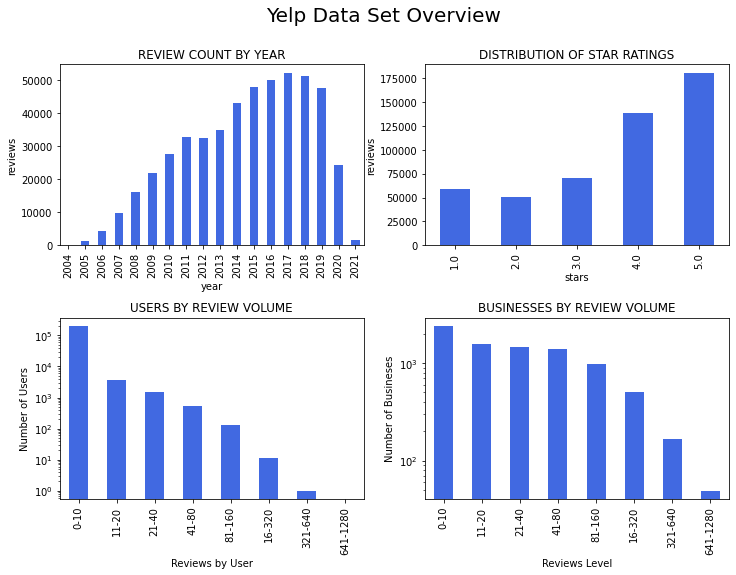

In [11]:
#@title Yelp Data Set Info {display-mode: "form"}
#@markdown The charts below show the data coverage of the full Yelp dataset. 
#@markdown A subset of the fields were extracted and massaged to create 
#@markdown a focused data set for the final project.

fig, axes = plt.subplots(2,2,  figsize=(12, 8), sharex=False, sharey=False)
fig.suptitle("Yelp Data Set Overview", fontsize=20)
plt.subplots_adjust(hspace=0.4)

# PLOT REVIEWS BY YEAR
ax = axes[0,0]    
fig.add_subplot(ax)
ds_train['date'].groupby(ds_train.date.dt.to_period("Y")).agg('count').plot(ax=ax,title='REVIEW COUNT BY YEAR', xlabel='year', ylabel='reviews', kind='bar', color='royalblue');

# PLOT REVIEWS BY STAR RATING
ax = axes[0,1]    
fig.add_subplot(ax)
ds_train['stars'].groupby(ds_train.stars).agg('count').plot(ax=ax, title='DISTRIBUTION OF STAR RATINGS', ylabel='reviews', kind='bar', color='royalblue');

# PLOT REVIEWS BY USER
ax = axes[1,0]    
fig.add_subplot(ax)
x = ds_train['user_id'].groupby(ds_train.user_id).agg('count').value_counts(bins=[0,10,20,40,80,160,320,640,1280]).round(0)
x.index = ['0-10', '11-20','21-40','41-80','81-160','16-320','321-640', '641-1280']
x.plot(ax=ax, kind='bar',
       xlabel='Reviews by User', 
       ylabel='Number of Users',
       title='USERS BY REVIEW VOLUME',
       color='royalblue',
       logy=True);

# PLOT REVIEWS PER RESTAURNT
ax = axes[1,1]    
fig.add_subplot(ax)
x = ds_train['BusinessName'].groupby(ds_train.BusinessName).agg('count').value_counts(bins=[0,10,20,40,80,160,320,640,3080])
x.index = ['0-10', '11-20','21-40','41-80','81-160','16-320','321-640', '641-1280']
x.plot(ax=ax, kind='bar',
       xlabel='Reviews Level', 
       ylabel='Number of Busineses',
       title='BUSINESSES BY REVIEW VOLUME',
       color='royalblue',
       logy=True);


  

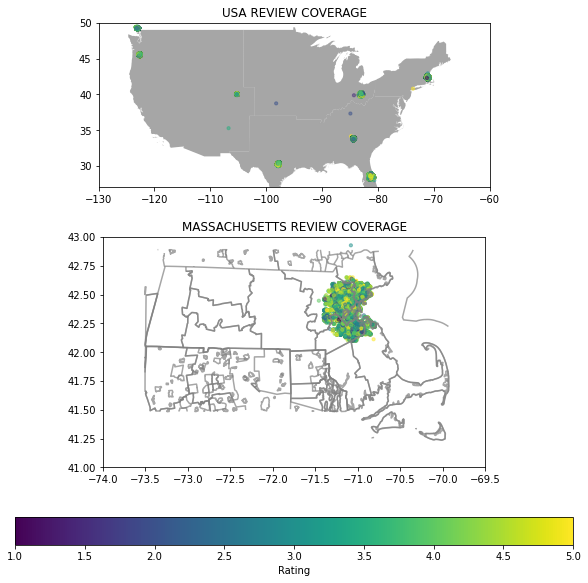

In [12]:
#@title Restaurant Locations in Yelp Dataset {display-mode: "form"}
#@markdown The the full Yelp data set covers 8 metro areas.  This project uses only data for Restaurants in Massachusetts 

# create figure and axes, assign to subplot
fig, axes = plt.subplots(2, 1, figsize=(10,10),
                         gridspec_kw={'height_ratios': [1, 2]},
                         sharex=False, sharey=False)

# US GEOGRAPHIC REVIEW COVERAGE
us_map = HOMEDIR + "cb_2018_us_region_5m.shp"

usdat = business_df[['longitude', 'latitude', 'state', 'rating']]
# United States
lat_min = 27.0
lat_max = 50.0
lon_min = -130.0
lon_max = -60.0

us_street_map = gpd.read_file(us_map)
crs = CRS('EPSG:4326')
us_geometry = [Point(xy) for xy in zip(usdat['longitude'], usdat['latitude'])]
us_geo_df = gpd.GeoDataFrame(usdat, crs = crs, geometry = us_geometry)

ax = axes[0]
us_street_map.plot(ax=ax, alpha=0.7,color='grey')
ax.title.set_text('USA REVIEW COVERAGE')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min,lat_max])
us_geo_df.plot(column='rating',ax=ax,alpha=0.5, 
            legend=False, markersize=10,
            legend_kwds={'label': "Rating", 'orientation': "horizontal"})


# MASSACHUSETTS GEOGRAPHIC REVIEW COVERAGE
#mass_map = HOMEDIR + "tl_2017_25_place.shp"
mass_map =  HOMEDIR + "massachusetts_administrative.shp"
#mass_map = "/content/drive/MyDrive/Colab Notebooks/ProjectDat/massachusetts_administrative.shp"

mdat = business_df[['longitude', 'latitude', 'state', 'rating']].copy()
# massacusetts
lat_min = 41.0
lat_max = 43.0
lon_min = -74.0
lon_max = -69.5

rev_in = len(mdat)
mdat =  mdat[(mdat['latitude'] >= lat_min) & 
(mdat['latitude'] < lat_max) &
(mdat['longitude'] >= lon_min) & 
(mdat['longitude'] <= lon_max)]

m_street_map = gpd.read_file(mass_map)
m_crs = CRS('EPSG:4326')
m_geometry = [Point(xy) for xy in zip(mdat['longitude'], mdat['latitude'])]
m_geo_df = gpd.GeoDataFrame(mdat, crs = m_crs, geometry = m_geometry)

ax = axes[1]

m_street_map.plot(ax=ax, alpha=0.7,color='grey')
ax.title.set_text('MASSACHUSETTS REVIEW COVERAGE')
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min,lat_max])
m_geo_df.plot(column='rating',ax=ax,alpha=0.5, 
            legend=True, markersize=10,
            legend_kwds={'label': "Rating", 'orientation': "horizontal"})



plt.show()

<a name="Sentiment"></a>
#IMPEMENTATION$:$ SENTIMENT ANALYSIS OF REVIEWS


In [13]:
#@title Understanding the Rating distributions
#@markdown The following histogram shows the distribution of the rating throughout all the yelp reviews. Let's look at the rating distribution to see whether there are more positive sentiments in regard to the restuarants than negative sentiments. For the purpose of data extraction, we will assume anything with a rating score of 3.0 and above to be a positive sentiment and anything less to be a negative sentiment. 

fig = px.histogram(ds_test, x="rating", 
                   width=500, height=300)
fig.update_traces(marker_color="royalblue", 
                  marker_line_color='white',
                  marker_line_width=1.5)
fig.update_layout(title_text='Reviewer Score',
                  xaxis_title="Review Rating",
                  yaxis_title="Number of Reviews")
fig.show(renderer="colab")
#fig.write_image("fig1.jpeg")

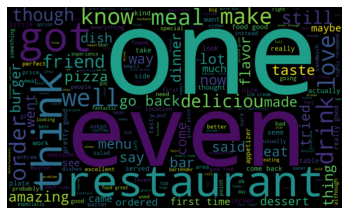

In [14]:
#@title Plotting the words and visualizing them
#@markdown We can generate a wordcloud using NLTK package to get an understanding of all the most common words within the corpus of reviews. Words that appear larger are words that are more frequent within the corpus. From a quick glance, most of the words are general words that will that will be filtered using background model.
warnings.filterwarnings('ignore')

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in ds_test.review)
wordcloud = WordCloud(stopwords=stopwords, height=600, width= 1000).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()


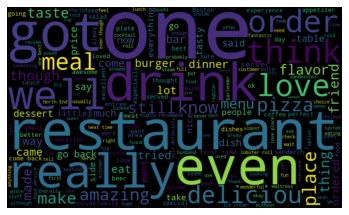

In [15]:
#@title Generating wordcloud for positive sentiments and negative sentiments
#@markdown We seperated the reviews into positive and negative sentiments by assigning a positive sentiment to reviews with a 3 or more stars. The results are skewed because there are significantly more positive than negative sentiments. Below is the wordcloud generated for the postive sentiments. 
warnings.filterwarnings('ignore')

ds_train = ds_train.iloc[0:100000,:] #Comment out this line for full training set
ds_train = ds_train[ds_train['rating'] != 3]
ds_train['sentiment'] = ds_train['rating'].apply(lambda rating : +1 if rating > 3 else -1)
positive = ds_train[ds_train['sentiment'] == 1]
negative = ds_train[ds_train['sentiment'] == -1]
ds_test = ds_test[ds_test['rating'] != 3]
ds_test['sentiment'] = ds_test['rating'].apply(lambda rating : +1 if rating > 3 else -1)
positive = ds_test[ds_test['sentiment'] == 1]
negative = ds_test[ds_test['sentiment'] == -1]
stopwords = set(STOPWORDS)
stopwords.update(["br", "href","good","great"])
## good and great removed because they were included in negative sentiment
pos = " ".join(review for review in positive.review)
wordcloud2 = WordCloud(stopwords=stopwords, height=600, width= 1000).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud22.png')
plt.show()

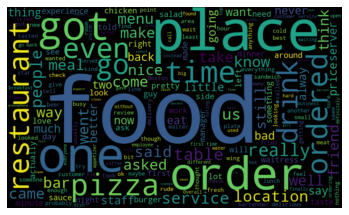

In [16]:
#@markdown The following wordcloud was generated for the negative senetiments. There are some overlaps of the words in the corpus between the positive and negative sentiments.
warnings.filterwarnings('ignore')

neg = " ".join(review for review in negative.review)
wordcloud3 = WordCloud(stopwords=stopwords, height=600, width= 1000).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

In [17]:
#@title Positive Sentiments vs Negative sentiments
#@markdown The next graph shows the amount of sentinements that are positive vs negative sentiments.
ds_train['sentimentt'] = ds_train['sentiment'].replace({-1 : 'negative'})
ds_train['sentimentt'] = ds_train['sentimentt'].replace({1 : 'positive'})
ds_test['sentimentt'] = ds_test['sentiment'].replace({-1 : 'negative'})
ds_test['sentimentt'] = ds_test['sentimentt'].replace({1 : 'positive'})

fig = px.histogram(ds_train, x="sentimentt", 
                   width=500, height=300)
fig.update_traces(marker_color="royalblue")
fig.update_layout(title_text='Review Sentiment',
                  xaxis_title="Sentiment",
                  yaxis_title="Number of Reviews")

fig.show(renderer="colab")

In [18]:
#@title Using VADER Lexicon model to sentiment 
#@markdown The NLTK library comes with the VADER pretrained model for sentiment analysis. It returns a compound value that ranges form -1 to 1. A value greater than 0 denotes a positive sentiment. The text was preprocessed to remove punctiation. The results show that the model struggles with negative sentiment significantly more than positive. This could be caused by a significant overlap in positive and negative words.  
warnings.filterwarnings('ignore')

def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
ds_train['review'] = ds_train['review'].apply(remove_punctuation)
ds_train = ds_train.dropna(subset=['review'])
ds_test['review'] = ds_test['review'].apply(remove_punctuation)
ds_train = ds_train.dropna(subset=['review'] )
#ds_train['Summary'] = ds_train['Summary'].apply(remove_punctuation)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(ds_train['review'])
test_matrix = vectorizer.transform(ds_test['review'])
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()


#ds_results['sentimentPredictionSIA'] = np.NaN
ds_results = []
for index in ds_test.index:
  if(sia.polarity_scores(ds_test["review"][index])['compound'] >= 0):
    #ds_results["sentimentPredictionSIA"][index]= 1
    ds_results.append(1)
  else: 
    #ds_results["sentimentPredictionSIA"][index] = -1
    ds_results.append(-1)
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
#confusion_matrix(ds_results['sentimentPredictionSIA'],ds_test['sentiment'])
confusion_matrix(ds_results, ds_test['sentiment'])

#print(classification_report(predictions,y_test))
print(classification_report(ds_results, ds_test['sentiment']))

              precision    recall  f1-score   support

          -1       0.35      0.21      0.27     10031
           1       0.90      0.95      0.92     75442

    accuracy                           0.86     85473
   macro avg       0.63      0.58      0.59     85473
weighted avg       0.84      0.86      0.85     85473



In [19]:
#@title Adjusting the corpus
#@markdown Since the negative sentiment results were significantly underperforming, we modified the review text preprocessing to remove word intersections to create more of a distinction in between the negative and positive reviews. However this didn't improve the model's negative predictions. Further research is required.
warnings.filterwarnings('ignore')

from collections import Counter
neg = neg.lower()
pos = pos.lower()
negList = neg.split(" ")
posList = pos.split(" ")
Counter = Counter(negList)
mostNeg = Counter.most_common(500)
mostNegList = [mostNegtuple[0] for mostNegtuple in mostNeg]
from collections import Counter
Counter = Counter(posList)
mostPos = Counter.most_common(500)
mostPosList = [mostPostuple[0] for mostPostuple in mostPos]

intersection = list(set(mostNegList)&set(mostPosList))


def remove_words(text):
  final = "".join(u for u in text if u not in intersection)
  return final 
ds_test['review'] = ds_test['review'].apply(remove_words)
ds_train = ds_train.dropna(subset=['review'] )

#ds_results['sentimentPredictionSIA2'] = np.NaN
ds_results = []


for index in ds_test.index:
  if(sia.polarity_scores(ds_test["review"][index])['compound'] >= 0):
    #ds_results["sentimentPredictionSIA2"][index]= 1
    ds_results.append(1)

  else: 
    #ds_results["sentimentPredictionSIA2"][index] = -1
     ds_results.append(-1)



# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
#confusion_matrix(ds_results['sentimentPredictionSIA2'],ds_test['sentiment'])
confusion_matrix(ds_results, ds_test['sentiment'])

#print(classification_report(predictions,y_test))
print(classification_report(ds_results, ds_test['sentiment']))

ds_sentiment = pd.DataFrame(ds_results, columns=['sentiment'])


              precision    recall  f1-score   support

          -1       0.46      0.12      0.20     22287
           1       0.75      0.95      0.84     63186

    accuracy                           0.73     85473
   macro avg       0.60      0.54      0.52     85473
weighted avg       0.68      0.73      0.67     85473



<a name="Topic"></a>
#IMPEMENTATION$:$ TOPIC MODEL AND DISCOVERY
LDA and MMF models were implemented to extract topic information from the review text in the Yelp data set. Each model had slightly different pre-processing stacks and requirements. The following modeling tools were used$:$
- scikit NMF
- scikit LDA
- Gensim LDA

Scikit NMF was implemented and prvided good results without much tweaking. LDA model tools from Scikit and Gensim were also implemented, each having different pre-processing requirements and strengths/weaknesses. Gensim had integrated support for coherence/perplexity measurement and prior data configuration. The scikit LDA seemed faster and used similar pre-processing as the NMF kit.

The main challenge for topic discovery is evaluating the results. This is an active academic subject for many researchers. We did not have a good automated metric for evaluating tuning parameters or data pre-processing techniques. Gensim provides perplexity and coherence measurements but optimizing based on these does not necessarily improve topic quality. Research papers indicate that coherence is better at predicting topic relevance [$[$1$]$](#references)[$[$2$]$](#references).  With this in mind, coherence was used as the criteria for an automated grid search to pick the number of topics and hyperparameters. Manunal topic evaluation was performed using pyLDAvis and a developed topic exploration tool that provides random reviews from a topic with relevant words marked.

Topic naming was also a challenge. Many topics were obvious but others were either junk or hard to determine from constituent words. In the end, topic naming was performed using visual inspection of the word distributions.

Despite the challenges, about 80% of topics discovered by the models from the review corpus were plausible. Visual inspection of reviews shows that most topic assignments make sense.




##Training LDA and NMF Models
  

In [20]:
#@title Model Training
#@markdown The code for training the models is included in the [Appendix](#appendix) 
#@markdown since it takes several hours to complete.  Training the model is not 
#@markdown required to run the rest of the scripts in this notebook since the trained 
#@markdown models are loaded by the startup script. The training scripts in the appendix
#@markdown will create new models that replace the ones shipped with this report.

In [21]:
#@title Model Word Mapping to Topics  {display-mode: "form"}
#@markdown The plots below show each topic for the model with the top words 
#@markdown that define it. Topics do not have a name but have the number 
#@markdown assigned by the topic model. The topics from different models 
#@markdown (e.g. NMF, LDA) do not match or use the same order.

#@markdown NOTE $:$ The **radio button** on the chart below allows you to choose between the LDA and NMF models.
#@markdown It takes a few second to create the plot, so be patient :).

# Heavily modified code from:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause


def plot_top_words(model, feature_names, n_top_words, title):
    num_topics = topic_count(model)
    # Set up grid dimensions
    grid_cols = 4
    plot_width = 12 
    grid_rows = (num_topics + grid_cols - 1) // grid_cols 
    plot_height = grid_rows * plot_width // grid_cols
    
    fig, axes = plt.subplots(grid_rows,grid_cols,  figsize=(plot_width, plot_height), sharex=True)
    ax_stack = []
    for topic_idx, (ax, topic) in enumerate(zip(axes.flatten(), model.components_)):
      if topic_idx >= num_topics:
        # if no more topics, clear unused plots on grid
        ax.set_axis_off() 
      else:
        ax_stack.append(ax)
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx }", fontdict={"fontsize": 18})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # add axis labels to last row
    for i in range(0, min(grid_cols, len(ax_stack))):  
      a = ax_stack.pop()
      a.xaxis.set_tick_params(which='both', labelbottom=True, rotation=0)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    output.clear()
    plt.show()

n_top_words = 15

def plot_topic_words(mod):
  output.clear()
  print('.. creating the plot. this takes a few seconds.')
  if mod == 'T':
    plot_top_words(
        nmf,
        tfidf_feature_names,
        n_top_words,
        "Topics in NMF Topics (generalized Kullback-Leibler divergence)",
    )

  if mod == 'L':
    plot_top_words(
      lda,
      tf_feature_names,
      n_top_words,
      "Topics in LDA Topics (Latent Dirichlet Allocation)",
    )

interactive(plot_topic_words, mod=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Choose Model', disabled=False))

interactive(children=(RadioButtons(description='Choose Model', options=(('NMF', 'T'), ('LDA', 'L')), value='T'…

In [22]:
#@title Scikit pyLDAvis LDA Model Visualization {display-mode: "form"}
#@markdown Another way to look at the topics produced by an LDA model is using 
#@markdown the pyLDAvis tool for visualization.  The **relevance slide bar** at the 
#@markdown upper-righthand corner allows adjustment of the weighting for the 
#@markdown bar chart below between the corpus and the individual review. 
#@markdown A setting of 1 puts all the emphasis on the weights from the 
#@markdown individual topic, and 0 puts all the emphasis on the weights in 
#@markdown the corpus. The authors of the pyLDAvis suggest a setting of about 
#@markdown 0.6 might provide a balanced view.


#@markdown NOTE: The topic numbers in pyLDAvis are ranked and **do not match the 
#@markdown model assigned topic numbers used in the previous plots above.** 
#@markdown Using the top few words of each topic is the most reliable identifier 
#@markdown across tools and plots. \

#@markdown Unfortunately, pyLDAvis does not support NMF models.

#@markdown The the figure below is an image.  Since the application does not start up 
#@markdown reliably in a notebook, the code to run the pyLDAvis is included in 
#@markdown Appendix [here](#pyLDAvis) for those interested in trying it live.


<p align="center"><img src="https://drive.google.com/uc?export=view&id=1Vv8dIR4wvL1L7pBrOkA4mGNmEwqbShSv", alt="pyLDAvis screenshot"
	title="pyLDAvis Topic Model Analysis" width="1000" height="600" /></p>



In [23]:
#@title Creating Topic Names{display-mode: "form"}   
#@markdown Run this cell to assign names to topics. The names are already configured 
#@markdown but you can edit them in this cell.
#@markdown
#@markdown Word distributions from each topic were manually analyzed to assign 
#@markdown a name. Next, the names were tested for plausibility by examining 
#@markdown the actual text of reviews. A 'text exploration' tool in the next 
#@markdown section aided this process.  The tool displays text from a random 
#@markdown review from a particular topic with relevant words highlighted 
#@markdown in color. This procedure provided an "acid" test to verify that 
#@markdown the names were relevant and accurate.

#@markdown EDIT AND RUN THIS CODE CELL TO CHANGE TOPIC NAMES

#@markdown **Topic Names List** \
#@markdown Topic ID Prefixes$:$ 'L'= scikit LDA, 'T' = scikit NMF, 'G' = Gensim LDA \

#@markdown Create dictionary **TOPIC_NAMES()** that  \ 
#@markdown cross refferences Topic ID (key) to Topic Name (value)

## EDIT THIS TO CHANGE TOPIC NAMES
TOPIC_NAMES = {'L0': '**Brunch-',
 'L1': 'Location-',
 'L2': '*Food',
 'L3': 'Visiting',
 'L4': 'Order/Delivery',
 'L5': '**Service',
 'L6': 'Middle Easter',
 'L7': 'Italian/Pasta',
 'L8': 'Payment',
 'L9': 'Burgers',
 'L10': 'Cuisine',
 'L11': '*Friendly Staff',
 'L12': 'Indian',
 'L13': '**Breakfast',
 'L14': 'Seafood',
 'L15': 'Experienc',
 'L16': 'Burritos',
 'L17': 'Sick/Complaint',
 'L18': 'Hearty',
 'L19': '*Bar/Location',
 'T0': '**Food',
 'T1': 'Pizza',
 'T2': 'Great Atmosphere',
 'T3': '**Wait',
 'T4': 'Seafood',
 'T5': '**Value',
 'T6': 'Coffee',
 'T7': 'Sushi',
 'T8': '**Deliver/Service',
 'T9': '**Recommend',
 'T10': 'Thai',
 'T11': 'Food2',
 'T12': 'Friendly Staff',
 'T13': 'Burger',
 'T14': '**Favorite',
 'T15': '*Bar/Fun',
 'T16': '*?LunchDinnerBuffet',
 'T17': '*Breakfast/Brunch',
 'T18': '*Sandwiches',
 'T19': 'Amazing'
}

pprint(TOPIC_NAMES)


{'L0': '**Brunch-',
 'L1': 'Location-',
 'L10': 'Cuisine',
 'L11': '*Friendly Staff',
 'L12': 'Indian',
 'L13': '**Breakfast',
 'L14': 'Seafood',
 'L15': 'Experienc',
 'L16': 'Burritos',
 'L17': 'Sick/Complaint',
 'L18': 'Hearty',
 'L19': '*Bar/Location',
 'L2': '*Food',
 'L3': 'Visiting',
 'L4': 'Order/Delivery',
 'L5': '**Service',
 'L6': 'Middle Easter',
 'L7': 'Italian/Pasta',
 'L8': 'Payment',
 'L9': 'Burgers',
 'T0': '**Food',
 'T1': 'Pizza',
 'T10': 'Thai',
 'T11': 'Food2',
 'T12': 'Friendly Staff',
 'T13': 'Burger',
 'T14': '**Favorite',
 'T15': '*Bar/Fun',
 'T16': '*?LunchDinnerBuffet',
 'T17': '*Breakfast/Brunch',
 'T18': '*Sandwiches',
 'T19': 'Amazing',
 'T2': 'Great Atmosphere',
 'T3': '**Wait',
 'T4': 'Seafood',
 'T5': '**Value',
 'T6': 'Coffee',
 'T7': 'Sushi',
 'T8': '**Deliver/Service',
 'T9': '**Recommend'}


<a name="Analysis"></a>
#USAGE$:$ ANALYZING CUSTOMER DATA WITH THE MODELS
In the previous sections, the training data set was used to create sentiment and topic models.  In this section, the models are used to predict topics and sentiment in the test data set.  

Scikit LDA Reviews with Topic: 99.9%
Scikit NMF Reviews with Topic: 99.9%
FINISHED TOPIC EXTRACTION 2021-12-12 12:35:37.105274-05:00


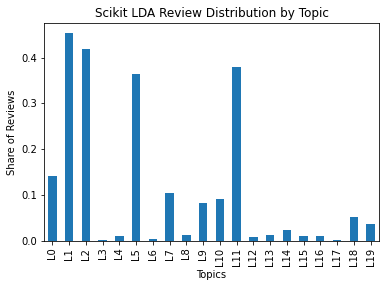

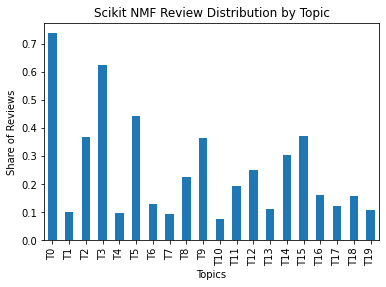

In [24]:
#@title Using the Model to Predict Topics in Reviews {display-mode: "form"}
#@markdown The Gensim and scikit models analyzed the test data set to assign 
#@markdown topics to reviews.
#@markdown Each model appends a column with the probability for each topic 
#@markdown to the review data set. The columns are designated as follows:
#@markdown - T0 - Tk for scikit NMF
#@markdown - L0 - Lk for scikit LDA
#@markdown - G0 - Gk for Gensim LDA \

#@markdown Low probability topics are set to zero based on a configured threshold.
#@markdown This allowed analysis to ignore unlikely topics. 

##### NEW RUN AGAINST TEST DATA SET #####
# Gensim LDA model
def genpredict_topics(model, ds, bow, threshold=.25, tag='G', caption=""):
  # model =     gensim lda model (lda_model)
  # reviews =   data set with reviews text from ds_test
  # bow = bag of works for review text
  # threshold = returns 0 for items < threshold
  # tag = prefix used in column identifier, e.g. G0, G1, ...
  # caption = the name of the model for the plot title
  # RETURNS = predictions dataframe shape [reviews x Topics]

  topics_out = model.get_document_topics(bow, minimum_probability=threshold)
  print(len(topics_out))
  num_topics  = len(model.print_topics(num_words=2))
  print('NUMTOPS', num_topics)
  num_reviews = ds.shape[0]
  topics_new = np.zeros((num_reviews, num_topics),dtype=int)
  print('top_out',len(topics_out), type(topics_out))
  print('topics_out[0]', topics_out[0])
  for x, tops in enumerate(topics_out):
    print('1')
    for t in tops:
      print('2')
      if t[1] > threshold and t[0] < num_topics:
        topics_new[x,t[0]] = 1
  
  topics_new = np.where(topics_new < threshold, 0, topics_new).round(3)   # zero out prob < threshold
  col_names = [tag + str(x) for x in range(0, topics_new.shape[1])]
  df_mat = pd.DataFrame(topics_new, columns = col_names)

  # show plot of topic distibution
  print('{} Reviews with Topic: {:.1f}%'.format(caption, 100*np.sum(np.sum(topics_new>0, axis=1)>0,axis=0) / num_reviews))
  x = np.sum(topics_new>0, axis=0) / num_reviews
  top_dist = pd.DataFrame(x.round(3).reshape(1,-1), columns=col_names)
  title = caption + ' Review Distribution by Topic'
  top_dist.T.plot(kind='bar', title=title,
                  xlabel='Topics', ylabel='Share of Reviews',
                  legend=False)
  return df_mat   # pandas dataframe shape (reviews x topics) 

# scikit LDA and NMF model predictions
def scipredict_topics(tfidf_fit, model, reviews, threshold=.02, tag='T', caption=""):
  # tfidf_fit = tfidf_fit (for NMF) or tf_fit (for LDA)
  # model =     nmf or lda model
  # reviews =   reviews text from ds_test
  # threshold = returns 0 for items < threshold
  # tag = prefix used in column identifier, e.g. T0, T1, ...
  # caption = the name of the model for the plot title
  # RETURNS = predictions dataframe shape [reviews x Topics]

  # NMF or LDA model prediction (ignore warning messages)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    tfidf_test = tfidf_fit.transform(reviews)          # vectorize
    topics_new = model.transform(tfidf_test)      # model prediction
  num_reviews = len(reviews)
  topics_new = np.where(topics_new < threshold, 0, topics_new).round(3)   # zero out prob < threshold
  col_names = [tag + str(x) for x in range(0, topics_new.shape[1])]
  df_mat = pd.DataFrame(topics_new, columns = col_names)
  
  # show plot of topic distibution
  print('{} Reviews with Topic: {:.1f}%'.format(caption, 100*np.sum(np.sum(topics_new>0, axis=1)>0,axis=0) / num_reviews))
  x = np.sum(topics_new>0, axis=0) / num_reviews
  top_dist = pd.DataFrame(x.round(3).reshape(1,-1), columns=col_names)
  title = caption + ' Review Distribution by Topic'
  top_dist.T.plot(kind='bar', title=title,
                  xlabel='Topics', ylabel='Share of Reviews',
                  legend=False)
  return df_mat   # pandas dataframe shape (reviews x topics) 

ds_topics = pd.DataFrame()
## Scikit LDA
tf_feature_names = tf_fit.get_feature_names_out()
ds_topics = pd.concat([ds_topics, scipredict_topics(tf_fit, lda, ds_testx.review, threshold=.15, tag='L', caption="Scikit LDA")], axis=1)
pd.concat([ds_test, ds_sentiment, ds_topics], axis=1)

## Scikit NMF
tfidf_feature_names = tfidf_fit.get_feature_names_out()
ds_topics = pd.concat([ds_topics, scipredict_topics(tfidf_fit, nmf, ds_testx.review, threshold=.001, tag='T', caption="Scikit NMF")], axis=1)

## Gensim LDA
#xx = genpredict_topics(lda_model, ds_test, bow_test, threshold=.15, tag='G', caption="Gensim LDA")
#ds_topics = pd.concat([ds_topics, xx], axis=1)

tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
print('FINISHED TOPIC EXTRACTION', datetime_NY)



In [25]:
#@title Explore Review Text by Topic {display-mode: "form"}   
#@markdown The Topic Exploration tool below enables a researcher to see the 
#@markdown model's performance with actual review text.  The slide bar selects 
#@markdown a topic, and the radio buttons choose the modeling technique 
#@markdown (NMF or LDA). Clicking the "Another Review" button displays the text of a 
#@markdown random review from the chosen topic. A user can click the button
#@markdown multiple times to see more reviews for the same topic. The top-10 
#@markdown most descriptive words for the topic are colored red, while the 
#@markdown following 20 most relevant words are colored green.
#@markdown
#@markdown The objective is to verify how accurately the model classifies 
#@markdown reviews by topic. The tool below helps the researcher understand 
#@markdown each topic's word distribution and map it to a descriptive name. 
#@markdown See Topic Names table.

#@markdown BE SURE TO RUN THIS CELL, OR ELSE YOU MAY NOT SEE RESULTS.

ds_final = pd.concat([ds_testx, ds_sentimentx, ds_topics], axis=1)

def topicwords(model, feature_names, no_top_words):
    l = []
    for topic_idx, topic in enumerate(model.components_):
         l.append(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    l = [c.split() for c in l]
    return(l)   

def topic_text(topic_no, another, tag):  
  no_top_words = 40
  if tag == 'L':
    topicToWords = topicwords(lda, tf_feature_names, no_top_words)
  else:  # if tag == 'T':
    topicToWords = topicwords(nmf, tfidf_feature_names, no_top_words)

  # Set pd so it won't truncate, set wrap parms
  pd.set_option('max_colwidth', 4000)
  pd.options.display.max_columns=400
  wrapper = textwrap.TextWrapper(width=100)

  num_topics = len([idx for idx in ds_final.columns if idx.startswith(tag)])

  output.clear()
  try:
    print(Back.BLUE + Fore.WHITE + 'TOPIC: ', TOPIC_NAMES[tag + str(topic_no)], Style.RESET_ALL)
  except:
    print(Back.BLUE + Fore.WHITE + 'TOPIC ', str(topic_no), Style.RESET_ALL,)

  w1 = topicToWords[topic_no][0:10]
  w2 = topicToWords[topic_no][11:40]
  print('\nTOPIC WORDS:', w1)
  print('            ', w2)
  print('             ', Back.RED + Fore.WHITE + "Top-!0 Prob", Style.RESET_ALL, "  ", Back.GREEN + Fore.WHITE + "Lower Prob" + Style.RESET_ALL)
  ds1 = ds_final[ds_final[tag + str(topic_no)] > 0 ]
  if len(ds1) == 0:
    print('No Reviews for this topic')
    return

  samp = randint(0, len(ds1)-1)
  cc = ds1.iloc[samp]['review'].lower()
  print('\n')
  print(Fore.BLUE, ds1.iloc[samp]['BusinessName'], Style.RESET_ALL,
        ds1.iloc[samp]['rating'], 'stars',
        'Topic Prob:', ds1.iloc[samp][tag + str(topic_no)])

  print('Review:', ds1.iloc[samp]['stars'],
        'Sentiment:', ds1.iloc[samp]['sentiment'])
  ccc = ""
  for word in str(cc).split(' '):
    if word in w1:
        ccc = ccc + Back.RED + Fore.WHITE + word + " "
    elif word in w2:
        ccc = ccc + Back.GREEN + Fore.WHITE + word + " "
    else:
        ccc = ccc + Style.RESET_ALL + word + " "
  #print('\n')
  print(wrapper.fill(text=ccc))

num_topics = len([idx for idx in ds_final.columns if idx.startswith('T')])

from google.colab import output

topic_no=IntSlider(min=0, max=num_topics-1, step=1, description='Select Topic:')
tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Model', disabled=False)
if True: #True no "view" button
  another = widgets.ToggleButton(
    value=False,
    description='Another Review',
    disabled=False)
  ui = widgets.HBox([topic_no, another, tag])
  out = interactive_output(topic_text, {'topic_no':topic_no, 'another':another, 'tag':tag})
  display(ui, out)
else:
  layout = Layout(display='hbox',
                    flex_flow='row',
                    align_items='stretch',
                    border='solid',
                    width='50%')
  wid=interactive(topic_text, {'manual' : True, 'manual_name' :'view text'}, 
                  topic_no=topic_no, tag=tag, layout=layout)

  controls = widgets.HBox(wid.children[:-1], layout = Layout(flex_flow='row wrap'))
  xout = wid.children[-1]
  print("View Review Text by Topic")
  display(widgets.VBox([controls, xout], layout=Layout(width='60%')))


Output()

In [26]:
#@title Final Data Set for Creating Reports
#@markdown The final data frame structure below shows the contextual review 
#@markdown data (e.g., location, date, customer) with topic classifications and 
#@markdown sentiment analysis.  This data allows users to create reports that 
#@markdown expose actionable information. \

#@markdown The following section provides some example reports derived from 
#@markdown model data. 

ds_final = pd.concat([ds_testx, ds_sentimentx, ds_topics], axis=1)
print(ds_final.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 53 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       100000 non-null  object        
 1   date          100000 non-null  datetime64[ns]
 2   stars         100000 non-null  float64       
 3   review        100000 non-null  object        
 4   BusinessName  100000 non-null  object        
 5   city          100000 non-null  object        
 6   state         100000 non-null  object        
 7   longitude     100000 non-null  float64       
 8   latitude      100000 non-null  float64       
 9   rating        100000 non-null  float64       
 10  review_count  100000 non-null  int64         
 11  categories    100000 non-null  object        
 12  sentiment     85473 non-null   float64       
 13  L0            100000 non-null  float64       
 14  L1            100000 non-null  float64       
 15  L2            1000

<a name="Reports"></a>
#USAGE$:$ CUSTOMER REPORTS: USING SENTIMENT AND TOPICS TO ANALYZE REVIEWS
Our restaurant review model analyzes Yelp reviews to develop 'dining-out' intelligence that better matches customer preferences with restaurant offerings.  Topic classification and sentiment analysis augment review data to provide a complete picture of the customer-restaurant relationship.  The combination enables better decision-making. 

This section provides some examples of reports generated from the model's data. 

In [27]:
#@title Top 5 Restaurants Topic with Positive Sentiment {display-mode: "form"}
#@markdown The lists below rank restaurants by customer sentiment for each \
#@markdown topic. The ranking is based on the average sentiment of reviews for \
#@markdown for the restaurant about the specific topic. \
#@markdown 
#@markdown You can choose "all" or a specific year.  The radio button chooses the\
#@markdown the topic model.  When 'Plot' is unchecked, a more detailed view is \
#@markdown shown.


# Calculate Top Restaurant Per Topic
# Concatenate data sets
ds_final = pd.concat([ds_testx, ds_sentimentx, ds_topics], axis=1)

def get_top10(ds, tcol, city):
    # ds=ds_final, tcol=topic column name (e.g. 'T1')
    print('a')
    top10 = ds[(ds['review_count'] > 10) & (ds[tcol] > 0) & (ds['city'] == city)]
    print('b')
    #print(top10.groupby('BusinessName').agg({'city':'first', 'review_count':'first', 'rating':'first', tcol:'count'}))
    print('b1')
    top10 = top10.groupby('BusinessName').agg({'city':'first', 'review_count':'first', 'rating':'first','sentiment':'mean', tcol:'count'})
    print('c')
    top10 = top10[top10[tcol] > 3].sort_values('sentiment', ascending=False)[0:5]
    print('d')
    return top10


def Show_SentByTopic(ds, city, tag, plot=True):
  # Sentiment by Topic
  # Choose reviews in topic for restaurants with > 10 reviews
  num_topics = len([idx for idx in ds.columns if idx.startswith(tag)])
  print('Recalculating - this will take a few seconds')
  if plot:
      # Set up plot grid dimensions
      grid_cols = 4
      plot_width = 12 
      grid_rows = (num_topics + grid_cols - 1) // grid_cols 
      plot_height = (grid_rows * plot_width // grid_cols) -4      
      fig, axes = plt.subplots(grid_rows,grid_cols,  figsize=(plot_width, plot_height), sharex=True)
      ax_stack = []
      title = 'Top-5 Restaurants by Topic '+ city
      fig.suptitle(title, fontsize=20)
      plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

      for x, ax in enumerate(axes.flatten()):
          print(x)
          t = tag + str(x)
          if x >= num_topics:
            # if no more topics, clear unused plots on grid
            ax.set_axis_off() 
          else:
            ax_stack.append(ax)
            print('1')
            top10 = get_top10(ds_final, t, city)
            print('2')
            top10 = top10[top10['sentiment'] > 0] 
            print('3')           
            rating = top10['sentiment']
            print('4')
            rating[rating < 0] = 0   #remove negative values
            restaurant = [a1[0:15] for a1 in top10.index.values] # shorten restaurant name
            print('5')
            # this converts the  restaurants list (top 10 by number of positive reviews)
            # to a string so that ax.text() can use it. Top 5 but some list <5.
            # Some restaurant lists have < 5 
            s = ""
            for z, r in enumerate(restaurant):
              print('z', z)
              s = s + r + '\n'
              if z > 5:
                break

            ax.text(x=0, y=.1, 
                    s=s, 
                    color='blue', verticalalignment='top')
            ax.set_axis_off()
            try:
              top = TOPIC_NAMES[tag + str(x)]
            except:
              top = f"Topic {x}"
            ax.set_title(top, fontdict={"fontsize": 14})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=10)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
      # add axis labels to last row
      for i in range(0, min(grid_cols, len(ax_stack))):  
          a = ax_stack.pop()
          a.xaxis.set_tick_params(which='both', labelbottom=True, rotation=0)
      output.clear()
      plt.show()
  else:  # not plot - detailed texy output
      for tcol in [idx for idx in ds.columns if idx.startswith(tag)]:
        try:
          print(Back.BLUE + Fore.WHITE + TOPIC_NAMES[tcol], Style.RESET_ALL)
        except:
          print(Back.BLUE + Fore.WHITE + 'TOPIC ', tcol, Style.RESET_ALL)
        print(get_top10(ds_final, tcol, city))
        print(' ')


## Displays pulldown, radio buttons, plot checkbox
ds=fixed(ds_final)
city=widgets.Dropdown(options=['Boston', 'Cambridge'], value='Cambridge', description='City', disabled=False)
tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Model', disabled=False)
plot=widgets.Checkbox(value=True, description='Plot')
ui = widgets.HBox([city, tag, plot])
out = interactive_output(Show_SentByTopic, {'ds':ds, 'tag':tag, 'city':city, 'plot':plot})
display(ui, out)

Output()

In [28]:
#@title Related Topics
#@markdown The heatmap below shows how often topics occur in the same review. 
#@markdown When multiple topics are covered in a review, there is a potential relationship. 
#@markdown The darker squares indicate when two topics co-occur more often.
#@markdown Some relationships are
#@markdown apparent (e.g., a positive sentiment for a friendly staff is related to
#@markdown positive feeling about the atmosphere and not waiting.)
#@markdown Some potential relationships may indicate potential opportunities$:$
#@markdown - 'Recommendations' are related to 'Great Atmosphere,', 'Value' and 
#@markdown a 'Fun/Bar'. So, serve some cocktails! :) 
#@markdown - It seems that shorter 'Waits', 'Fun Bar' and 'Value' increase sentiment
#@markdown across most other topics.
#@markdown - Food type (e.g. Thai, Seafood) doesn't seem to affect sentiment much across other topics.
#@markdown - These patterns don't seem to change year-by-year.
#@markdown 
#@markdown The topic and sentiment information provides insights. 
#@markdown The chart can expose many more opportunities for the restaurant owner.  
#@markdown Additional work is needed to understand the meaning of these topics.  
#@markdown Some topics may not be useful, but others may have hidden meanings not
#@markdown apparent at first glance. This only scratches the surface of possible
#@markdown analyses.  For example, heatmaps could show reviews with both positive 
#@markdown and negative sentiments.
#@markdown 
#@markdown The darker squares indicate more frequent co-occurrences. The pulldown
#@markdown menu chooses one or all years.  The radio buttons select
#@markdown the model (NMF or LDA) that generated the topics.
ds_final = pd.concat([ds_testx, ds_sentimentx, ds_topics], axis=1)

def plot_related_topics(dds, tag, year='0000'):
    top_cols = [idx for idx in dds.columns if idx.startswith(tag)]
    top_names = [TOPIC_NAMES[tid] for tid in top_cols]

    # select year or '0000 for all
    if year in [str(y) for y in range(2005, 2021)]:
      ds = dds[dds.date.dt.to_period("Y") == '2010']
      YEAR = year
    else:
      ds = dds
      YEAR = 'All Years' 

    # select positive or negative sentiment data
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle("Topic Relationships " + YEAR, fontsize=20)
    dp = ds[ds.sentiment > 0]
    SENT = 'Positive Sentiment'
    dp = dp.loc[:,top_cols]
    dp.columns = top_names 
    dp = dp.astype(bool).astype(int)
    dp = dp.T.dot(dp)
    np.fill_diagonal(dp.values, 0)

    cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
    
    sns.heatmap(dp, ax=ax, cmap=cmap, cbar=False)
    ax.set_title(SENT)
    ax.invert_yaxis()   
    plt.show()


dds = fixed(ds_final)
yearlist = ['All']
yearlist.extend([str(y) for y in range(2005, 2021)])
year=widgets.Dropdown(options=[str(y) for y in yearlist], value='All', description='Year', disabled=False)
tag=RadioButtons(options=[('NMF','T'),('LDA', 'L')], description='Model', disabled=False )
ui = widgets.HBox([year, tag])
out = interactive_output(plot_related_topics, {'dds':dds, 'tag':tag, 'year':year})
display(ui, out)

Output()

<a name="appendix"></a>
#Appendix
This section has scripts that take a long time to execute and/or require the user to download additional data sets.  The output data from these scripts is loaded at start up so is not needed to run the rest of the notebook.  Running these scripts will update the data files

In [29]:
#@title Yelp Dataset Extraction Scripts {display-mode: "form"}
#@markdown **WARNING THIS REQUIRES YOU TO DOWNLOAD THE YELP JSON FILES.** \
#@markdown This section is provided for completeness but is not required 
#@markdown to run the remaining cells in this notebook since the extracted data set files are provided.  The data set is 10GB 
#@markdown and takes an more than an hour to complete.  The dataset is available at [Yelp Open Dataset](https://www.yelp.com/dataset) 
#@markdown Put the JSON files in the directory defined by the HOMEDIR variable.
#@markdown
#@markdown NOTE: To run, you need to edit the first "if statement" to True.
#@markdown This is disabled so that folks running all cells don't have to wait hours. 
if False:  # to run, change this to True
  import json
  import numpy as np
  import pandas as pd
  import pickle
  from sklearn.model_selection import train_test_split

  # YOU NEED TO CHANGE THIS TO THE DIRECTORY FOR THE YELP JSON FILES 
  # download: https://www.yelp.com/dataset 
  xHOMEDIR = ''  #HOMEDIR  # use HOMEDIR or other directory for pocesssing
  #######

  REVIEW = xHOMEDIR + 'yelp_academic_dataset_review.json'
  TIP = xHOMEDIR + 'yelp_academic_dataset_tip.json'
  CHECKIN = xHOMEDIR + 'yelp_academic_dataset_checkin.json'
  USER = xHOMEDIR + 'yelp_academic_dataset_user.json'
  BUSINESS = xHOMEDIR + 'yelp_academic_dataset_business.json'


  ####################
  # LOAD REVIEw DATA
  review_data = []
  try:
    with open(REVIEW) as f:
      for line in f:
          review_data.append(json.loads(line))
  except:
    print('Yelp JSON files are not in the HOMEDIR directory. You can download these files from https://www.yelp.com/dataset.')
    print('NOTE: You do not need to run this cell to run the rest of the cells in this notebook')
    raise
  review_df = pd.DataFrame.from_dict(review_data)
  print('Before NaN Drop', len(review_df))
  review_df = review_df.dropna(how='any')
  print('After NaN Drop', len(review_df))

  review_df = review_df.rename(columns = {'text': 'review'})
  review_df = review_df[['business_id', 'user_id', 'date', 'stars', 'review']]
  print(review_df)

  #####################
  # LOAD BUSINESS DATA
  business_data = []
  with open(BUSINESS) as f:
      for line in f:
          business_data.append(json.loads(line))
  business_df = pd.DataFrame.from_dict(business_data)
  business_df = business_df.rename(columns = {'name': 'BusinessName', 'stars': 'rating'})

  business_df = business_df[['business_id', 'BusinessName','city', 'state', 'longitude', 'latitude', 'rating', 'review_count', 'categories' ]]

  print(business_df.head())

  #####################
  # Join reviews with busines
  yelp_ds1 = review_df.set_index('business_id').join(business_df.set_index('business_id'), on='business_id', how='left')

  yelp_ds1.reset_index(drop=True, inplace=True)
  print('Length:', len(yelp_ds1))
  yelp_ds1.head()

  #####################
  ## FINAL PROCESSING OF DATA SET

  # Remove NaNs
  print('Before Length', len(yelp_ds1))
  yelp_ds1 = yelp_ds1.dropna(how='any')
  print('After NaN Drop', len(yelp_ds1))

  ## Get restaurants only
  yelp_ds1 = yelp_ds1[yelp_ds1['categories'].str.contains("Restaurant")]
  print('Restaurants', len(yelp_ds1))

  ##  Get Massachusetts only
  # massacusetts
  lat_min = 41.0
  lat_max = 43.0
  lon_min = -74.0
  lon_max = -69.5

  rev_in = len(yelp_ds1)
  yelp_ds1 =  yelp_ds1[(yelp_ds1['latitude'] >= lat_min) & 
  (yelp_ds1['latitude'] < lat_max) &
  (yelp_ds1['longitude'] >= lon_min) & 
  (yelp_ds1['longitude'] <= lon_max)]
  print('In Range Reviews', len(yelp_ds1), 'Out of Range Reviews', rev_in - len(yelp_ds1))

  # old MA
  #print('States before', yelp_ds1.groupby('state').count())
  #yelp_ds1 = yelp_ds1[yelp_ds1['state'] == 'MA']
  #print('Massachusetts')
  #yelp_ds1.groupby('state').count()

  ## Fix date format 
  yelp_ds1['date'] = pd.to_datetime(yelp_ds1['date'])

  ##################
  # SAVE DATASETs
  import pickle
  xDF_SAVE = xHOMEDIR + 'xyelp_dsMA.csv'
  xDSREV_SAVE = xHOMEDIR + 'xds_yelp_rev_dsMA'
  xDSBIZ_SAVE = xHOMEDIR + 'xds_yelp_biz_dsMA'
  xDSTRAIN = xHOMEDIR + 'cs410' + DSID + '_xds_train'
  xDSTEST = xHOMEDIR + 'cs410' + DSID + '_xds_test'

  # SAVE DATA SET TO CSV
  yelp_ds1.to_csv(xDF_SAVE)

  # SAVE DATA SET & Busines Data Set via pickle (if you want))
  import pickle

  #yelp_ds1.reset_index(drop=True, inplace=True) 
  #with open(xDSREV_SAVE, 'wb') as f:
  #  pickle.dump(yelp_ds1, f)

  #business_df.reset_index(drop=True, inplace=True) 
  #with open(xBIZ_SAVE, 'wb') as f:
  #  pickle.dump(business_df, f)

  ds = pd.read_csv(xDF_SAVE)
  ds_train, ds_test = train_test_split(ds, test_size=0.2, random_state=25)
  ds_train.reset_index(drop=True, inplace=True)
  ds_test.reset_index(drop=True, inplace=True)

  # Save Models to Disk 
  with open(xDSTRAIN, 'wb') as f:
      pickle.dump(ds_train, f)

  with open(xDSTEST_NMF, 'wb') as f:
      pickle.dump(ds_test, f)





In [30]:
#@title Train NMF and NMF Models Models {display-mode: "form"}
#@markdown NOTE: This cell takes several hour to run.  
#@markdown The resulting datasets are loaded in the initial cell in this notebook.
#@markdown so you can skip this and run the rest of the cells.

#@markdown NOTE: To run, you need to edit the first "if statement" to True.
#@markdown This is disabled so that folks running all cells don't have to wait hours. 
if False:  # change to True if you want run

  # Setting this to True will overwrite the default files
  #  RECMMENDED: False = new version for current session but running first cell reloads default files
  SAVE_RESULTS = False 

  # PREPROCESS DATA FOR SCIKIT NMF & LDA###
  documents = ds_train.review

  # Add additional stop words for removal during proprocessing.
  # These stop words are added to the standard English stopwords from the scikit 
  # package. Defining these removes non-predictive words that that appear across topics.
  _stoplist =  ['18', '20', '30', 'absolutely', 'asked', 'better', 'bit', 'came', 'com', 
            'come', 'did', 'didn', 'don', 'fi', 'food', 'going', 'got', 'just', 'know', 
            'la', 'like', 'lot', 'love', 'make', 'nice', 'ok', 'place', 'probably', 
            'really', 'restaurant', 'said', 'sat', 'say', 'sit', 'thing', 'think', 
            'today', 'told', 'try', 'usually', 've', 'want', 'way', 'went', 'wi', 
            'www', 'ya']
  stop_list = list(set(_stoplist))
  stop_list.sort()

  my_stopwords = text.ENGLISH_STOP_WORDS.union(stop_list)

  no_features =100000

  # scikit NMF tf-idf preprocessing
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=my_stopwords)
  tfidf_fit = tfidf_vectorizer.fit(documents)
  tfidf = tfidf_fit.transform(documents)
  tfidf_test = tfidf_fit.transform(ds_test.review)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

  # scikity LDA uses raw term counts because it is a probabilistic graphical model
  tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=my_stopwords)
  tf_fit = tf_vectorizer.fit(documents)
  tf = tf_fit.transform(documents)
  tf_feature_names = tf_vectorizer.get_feature_names_out()

  ### TRAIN NMF AND LDA MODELS

  no_topics = 20

  # TRAIN SCIKIT NMF
  with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

  # TRAIN SCIKIT LDA
  lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

  # Save Models to Disk 
  if SAVE_RESULTS:
    with open(SCIMODEL_LDA, 'wb') as f:
      pickle.dump(lda, f)

    with open(SCIMODEL_NMF, 'wb') as f:
      pickle.dump(nmf, f)

    with open(SCIMODEL_TFNMF, 'wb') as f:
      pickle.dump(tfidf_fit, f)

    with open(SCIMODEL_TFNMF_VECT, 'wb') as f:
      pickle.dump(tfidf_vectorizer, f)

    with open(SCIMODEL_TFNMF_TFIDF, 'wb') as f:
      pickle.dump(tfidf, f)

    with open(SCIMODEL_NMF_FEATURES, 'wb') as f:
      pickle.dump(tfidf_feature_names, f)


    with open(SCIMODEL_TFLDA, 'wb') as f:
      pickle.dump(tf_fit, f)

    with open(SCIMODEL_TFLDA_VECT, 'wb') as f:
      pickle.dump(tf_vectorizer, f)

    with open(SCIMODEL_TFLDA_TF, 'wb') as f:
      pickle.dump(tf, f)
  
    with open(SCIMODEL_LDA_FEATURES, 'wb') as f:
      pickle.dump(tf_feature_names, f)


  tz_NY = pytz.timezone('America/New_York') 
  datetime_NY = datetime.now(tz_NY)
  print('FINISHED TRAINING', datetime_NY)


In [3]:
#@title Scikit pyLDAvis LDA Model Visualization {display-mode: "form"}
#@markdown <a name="pyLDAvis"></a>
#@markdown **NOTE:** THIS CELL IS NOT PART OF THIS REPORT BUT INCLUDED IN THE APPENDIX FOR THOSE INTERESTED IN TRYING THE TOOL.

#@markdown pyLDAvis is a 3rd party tool for visualizing Topic Models. While useful, it's does not run
#@markdown reliably in this format. It makes some assumptions about installed package versions
#@markdown that cause eratic behavior.  You can **try to** run the application by doing the following:
#@markdown - Run this cell and watch it fail (If it succeeds, have fun playing thi the tool!).
#@markdown - Restart the kernel by clicking "Runtime" on the Colab menu and selecting "Restart runtime".
#@markdown - Reload the configuraion and data sets 
#@markdown - Run this cell again. (It may or may not work.)
#@markdown 
#@markdown pyLDAvis was useful during development but not necessary to meet the requirements of this report.

from __future__ import print_function 
if 'pyLDAvis' not in sys.modules:
  !pip -q install pyLDAvis | grep -v 'satisfied|DeprecationWa'
import pyLDAvis
import pyLDAvis.sklearn

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer) 

vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.260165 -0.055783       1        1  18.198663
1     -0.235090  0.149479       2        1  16.748930
5     -0.193979  0.187570       3        1  16.249273
11    -0.225633  0.027056       4        1  11.000044
0     -0.204750 -0.064058       5        1   5.803689
7     -0.117100 -0.175844       6        1   5.187828
10    -0.158453 -0.134906       7        1   4.137851
9     -0.125237  0.009372       8        1   3.759802
18     0.008849 -0.274544       9        1   3.330598
19    -0.002789  0.191413      10        1   2.915405
15     0.059943  0.049211      11        1   1.893951
8      0.085305  0.163371      12        1   1.814034
14     0.090625 -0.201917      13        1   1.599980
13     0.083456  0.041189      14        1   1.581586
16     0.165474  0.101320      15        1   1.273964
4      0.154574  0.065964      16        1   1.201442
12     0.193377 -0.030038      17        1   0.911692
6      0.225574 -0.014782      18        1   0.897170
3      0.220094 -0.023124      19        1   0.824931
17     0.235926 -0.010951      20        1   0.669167, topic_info=                Term          Freq         Total Category  logprob  loglift
21918          order  17277.000000  17277.000000  Default  30.0000  30.0000
14159          great  39090.000000  39090.000000  Default  29.0000  29.0000
27688        service  28129.000000  28129.000000  Default  28.0000  28.0000
6288         chicken  16886.000000  16886.000000  Default  27.0000  27.0000
18404        lobster   6943.000000   6943.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
12987     friendlier     88.998720     89.958280  Topic20  -5.6316   4.9962
7223      complaints    334.415008    645.329303  Topic20  -4.3078   4.3495
11218  establishment    203.592694   1281.985598  Topic20  -4.8041   3.1668
17943             le     97.474735    188.647168  Topic20  -5.5406   4.3466
33425          venue     97.916165    382.875326  Topic20  -5.5361   3.6433

[1116 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
24         2  0.265629         10
24         3  0.647701         10
24         4  0.055800         10
24         6  0.013950         10
24         9  0.016662         10
...      ...       ...        ...
34832     11  0.018607      years
34832     12  0.043824      years
34832     14  0.045783      years
34874     16  0.997781  yesterday
35056     15  0.997507       zero

[2337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 12, 1, 8, 11, 10, 19, 20, 16, 9, 15, 14, 17, 5, 13, 7, 4, 18])

<a name="references"></a>
#References
[1]  **Reading Tea Leaves: How Humans Interpret Topic Models** <br>
Jonathan Chang, Jordan Boyd-Graber, Sean Gerrish, Chong Wang, David M. Blei<br>
https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf

[2] **Evaluating Topic Models**<br>
Matti Lyra<br>
Pydata Conference 2019 Berlin Presentation, Video<br>
https://www.youtube.com/watch?v=UkmIljRIG_M 